In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('Data/spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
# Under sampling to handel imbalance data

df_spam = df[df['Category']=='spam']

df_ham = df[df['Category']=='ham']
df_ham.shape
df_ham_downsample = df_ham.sample(df_spam.shape[0])


df_spam.shape, df_ham_downsample.shape

((747, 2), (747, 2))

In [5]:
df_balanced = pd.concat([df_spam, df_ham_downsample])
df_balanced.shape

(1494, 2)

In [6]:
df_balanced['Category'].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

In [7]:
df_balanced.sample(5)

,Category,Message
989,ham,Yun ah.the ubi one say if ü wan call by tomorr...
67,spam,Urgent UR awarded a complimentary trip to Euro...
375,spam,"Thanks for your Ringtone Order, Reference T91...."
1137,spam,Dont forget you can place as many FREE Request...
789,spam,"5 Free Top Polyphonic Tones call 087018728737,..."


In [8]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x =='spam' else 0)

In [9]:
df_balanced.sample(5)

,Category,Message,spam
2308,spam,WIN a year supply of CDs 4 a store of ur choic...,1
15,spam,"XXXMobileMovieClub: To use your credit, click ...",1
3742,spam,2/2 146tf150p,1
2269,spam,88066 FROM 88066 LOST 3POUND HELP,1
2288,ham,Alex knows a guy who sells mids but he's down ...,0


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [11]:
X_train.head()

1252    Please CALL 08712402779 immediately as there i...
4729    I (Career Tel) have added u as a contact on IN...
3075                  Don know. I did't msg him recently.
1392                  Haha just kidding, papa needs drugs
4754    Cashbin.co.uk (Get lots of cash this weekend!)...
Name: Message, dtype: object

In [12]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [13]:
def get_sentence_embedding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [14]:
get_sentence_embedding([
    'The house is on the water with a dock',
    "I'll meet you in the lobby",
    'I love you Nishu'
])

<tf.Tensor: shape=(3, 768), dtype=float32, numpy=
array([[-0.88353497, -0.20798926, -0.03419311, ...,  0.00590114,
        -0.58766824,  0.9240191 ],
       [-0.8759218 , -0.19461296, -0.15719081, ..., -0.07320428,
        -0.6252252 ,  0.9392338 ],
       [-0.9085815 , -0.47692683, -0.7572337 , ..., -0.40943635,
        -0.7385911 ,  0.9035303 ]], dtype=float32)>

In [15]:
e = get_sentence_embedding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

In [16]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.76071954, -0.14222385,  0.49599463, ...,  0.4215405 ,
        -0.53218514,  0.80314916],
       [-0.86038685, -0.21262017,  0.49019018, ...,  0.39687657,
        -0.6052787 ,  0.8448607 ],
       [-0.71292734, -0.15472871,  0.3831082 , ...,  0.35231316,
        -0.51005566,  0.7348722 ],
       [-0.8254045 , -0.35560212, -0.5906005 , ..., -0.01563795,
        -0.61412346,  0.8723322 ],
       [-0.7502036 , -0.268037  , -0.267203  , ...,  0.02813728,
        -0.5936459 ,  0.7974844 ],
       [-0.78568745, -0.2996764 ,  0.41004923, ...,  0.5222164 ,
        -0.49591416,  0.81539726]], dtype=float32)>

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]], [e[2]])

array([[0.9954065]], dtype=float32)

In [18]:
# Creating Functional Model
# BERT Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
output = bert_encoder(preprocessed_text)

#Neural Network Layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(output['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# Construct final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [20]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [21]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 30s 646ms/step - loss: 0.6527 - accuracy: 0.6187 - precision: 0.6211 - recall: 0.6089
Epoch 2/10
35/35 [==============================] - 23s 665ms/step - loss: 0.5254 - accuracy: 0.7893 - precision: 0.7664 - recall: 0.8321
Epoch 3/10
35/35 [==============================] - 24s 672ms/step - loss: 0.4556 - accuracy: 0.8366 - precision: 0.8222 - recall: 0.8589
Epoch 4/10
35/35 [==============================] - 24s 677ms/step - loss: 0.4062 - accuracy: 0.8679 - precision: 0.8515 - recall: 0.8911
Epoch 5/10
35/35 [==============================] - 41s 1s/step - loss: 0.3821 - accuracy: 0.8741 - precision: 0.8581 - recall: 0.8964
Epoch 6/10
35/35 [==============================] - 23s 668ms/step - loss: 0.3562 - accuracy: 0.8813 - precision: 0.8700 - recall: 0.8964
Epoch 7/10
35/35 [==============================] - 23s 666ms/step - loss: 0.3407 - accuracy: 0.8804 - precision: 0.8685 - recall: 0.8964
Epoch 8/10
35/35 [===================

In [22]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 9s 602ms/step - loss: 0.2697 - accuracy: 0.9385 - precision: 0.9271 - recall: 0.9519


[0.26973864436149597,
 0.9385026693344116,
 0.9270833134651184,
 0.9518716335296631]

In [23]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

12/12 [==============================] - 9s 632ms/step


In [24]:
y_predicted = np.where(y_pred>0.5,1,0)
y_predicted

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[173,  14],
       [  9, 178]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

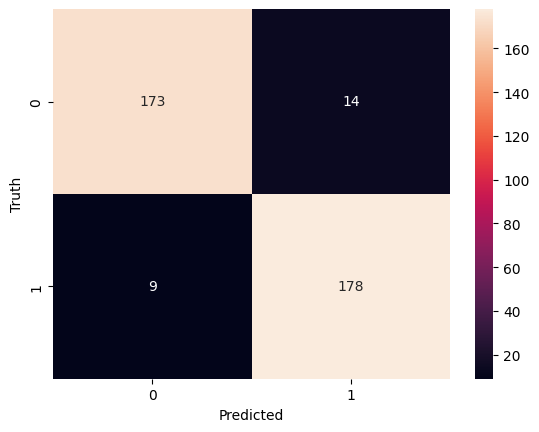

In [26]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [27]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       187
           1       0.93      0.95      0.94       187

    accuracy                           0.94       374
   macro avg       0.94      0.94      0.94       374
weighted avg       0.94      0.94      0.94       374



In [28]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 924ms/step


array([[0.7699907 ],
       [0.85352737],
       [0.8175998 ],
       [0.22767216],
       [0.10114224]], dtype=float32)

In [29]:
# First 3 looks like spam

In [30]:
model.save("tf_serving/saved_models/1")

INFO:tensorflow:Assets written to: tf_serving/saved_models/1\assets


INFO:tensorflow:Assets written to: tf_serving/saved_models/1\assets


In [31]:
model.save("tf_serving/saved_models/2")

INFO:tensorflow:Assets written to: tf_serving/saved_models/2\assets


INFO:tensorflow:Assets written to: tf_serving/saved_models/2\assets


In [32]:
model.save("tf_serving/saved_models/3")

INFO:tensorflow:Assets written to: tf_serving/saved_models/3\assets


INFO:tensorflow:Assets written to: tf_serving/saved_models/3\assets
